In [1]:
import numpy as np
from dataclasses import dataclass

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
@dataclass
class Cell():
    alive: bool = False

    def set(self,state):
        self.alive = state

    def get(self):
        return self.alive
    
class Lattice():
    def __init__(self,size: int):
        self.size = size
        self.grid = np.array([[Cell() for i in range(self.size)] for j in range(self.size)])

    def set_state(self, idx: list[tuple[int,int]], state: bool):
        row_idx = [row for row, _ in idx]
        col_idx = [col for _, col in idx]

        for cell in self.grid[row_idx,col_idx]:
            cell.set(state)


    def get_states(self, grid = None):
        if grid is not None:
            return np.array([[cell.get() for cell in row] for row in grid])
        else:
            return np.array([[cell.get() for cell in row] for row in self.grid])
    
    def plot(self, ax = None):
        data_ = self.get_states()
        if ax is not None:
            self.img = ax.imshow(data_, cmap='rocket_r', interpolation='nearest') #sns.heatmap(data_,cbar=False,linewidths=0.1,xticklabels=False,yticklabels=False,cmap='rocket_r',ax = ax)
        else:
            self.img = plt.imshow(data_, cmap='rocket_r', interpolation='nearest') #sns.heatmap(data_,cbar=False,linewidths=0.1,xticklabels=False,yticklabels=False,cmap='rocket_r')
        

    # def animate(self, frame):
    #     self.update()
    #     self.img.set_data(self.get_states())
    #     return [self.img]
        

    def update(self):
        # bottom
        bottom = self.get_states(np.roll(self.grid,-1,axis=0)).astype(int)
        # up
        up = self.get_states(np.roll(self.grid,1,axis=0)).astype(int)
        # right
        right = self.get_states(np.roll(self.grid,-1,axis=1)).astype(int)
        # left 
        left = self.get_states(np.roll(self.grid,1,axis=1)).astype(int)
        # upper right
        upper_right = self.get_states(np.roll(np.roll(self.grid,-1,axis=1),1,axis=0)).astype(int)
        # upper left
        upper_left = self.get_states(np.roll(np.roll(self.grid,1,axis=1),1,axis=0)).astype(int)
        # bottom right
        bottom_right = self.get_states(np.roll(np.roll(self.grid,-1,axis=1),-1,axis=0)).astype(int)
        # bottom left
        bottom_left = self.get_states(np.roll(np.roll(self.grid,1,axis=1),-1,axis=0)).astype(int)

        live_or_die = bottom + up + right + left + upper_left + upper_right + bottom_left + bottom_right # number of live nbrs

        # update according to Conway's Game of Life
        # conditions for live cells
        underpopulation = np.where( (live_or_die < 2) & (self.get_states() == True) ) # dies
        overpopulation = np.where( (live_or_die > 3) & (self.get_states() == True) ) # dies
        stable = np.where( ( (live_or_die == 2) | (live_or_die == 3) ) & (self.get_states() == True) ) # lives

        # conditions for dead cells
        reborn = np.where((live_or_die == 3) & (self.get_states() == False)) # lives

        # update
        for cell in self.grid[*underpopulation]:
            cell.set(False)

        for cell in self.grid[*overpopulation]:
            cell.set(False)

        for cell in self.grid[*stable]:
            cell.set(True)

        for cell in self.grid[*reborn]:
            cell.set(True)


        


* Any live cell with fewer than two live neighbours dies, as if by underpopulation.

* Any live cell with two or three live neighbours lives on to the next generation.

* Any live cell with more than three live neighbours dies, as if by overpopulation.

* Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction

In [245]:
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
import time

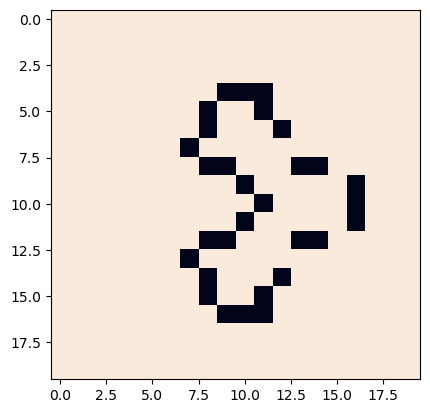

In [4]:
N = 20
lattice = Lattice(N)

blinker = [(2,1), (2,2), (2,3)]

foo = [(2, 14), (1, 15), (2, 15), (0, 16), (1, 16), (1, 17), (2, 18), (5, 18), (6, 18), (4, 19), (5, 19), (6, 19)]


lattice.set_state(foo,True)

fig, ax = plt.subplots()

lattice.plot()

# def animate(frame):
#     print(frame)

#     lattice.update()  # Update the grid based on the Game of Life rules
#     lattice.img.set_data(lattice.get_states())  # Update the plot data

#     return [lattice.img]

# ani = FuncAnimation(
#     fig,          # The figure to animate
#     animate, # The update function to call at each frame
#     frames=100,   # Number of frames (can also be an iterable)
#     interval=500,  # Time between frames in milliseconds
#     blit=False     # Whether to use blitting for efficiency (only redrawing the parts that change)
# )


   
